In [1]:
import sys
sys.path.append("../")  

import numpy as np 
import math, torch, time
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR, MultiplicativeLR
import torch.nn as nn
import matplotlib.pyplot as plt
import sys, os
import mpl_toolkits.mplot3d as p3d
from scipy import linalg
import utility, problem
import random
import net
from scipy.linalg import lstsq

def set_seed(seed=42):
    random.seed(seed)             # Python 内置随机数种子
    np.random.seed(seed)          # NumPy 随机数种子
    torch.manual_seed(seed)       # PyTorch CPU 随机数种子
    torch.cuda.manual_seed(seed)  # PyTorch GPU 随机数种子
    torch.cuda.manual_seed_all(seed)  # 多 GPU 训练时设定所有 GPU 相同种子
    torch.backends.cudnn.deterministic = True  # 保证 CUDA 计算的确定性
    torch.backends.cudnn.benchmark = False  # 关闭自动优化（可能影响速度）

# 设置随机种子
set_seed(42)

In [2]:
torch.set_default_dtype(torch.float64)
plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': [8, 8]
})
def u_exact(x):
    if x.ndim == 1:
        x1 = x[0]
        x2 = x[1]
    else:
        x1 = x[:,0]
        x2 = x[:,1]
    return torch.sin(torch.pi*x1)*torch.sin(torch.pi*x2)

def f(x):
    if x.ndim == 1:
        x1 = x[0]
        x2 = x[1]
    else:
        x1 = x[:,0]
        x2 = x[:,1]
    return 2*torch.pi**2*torch.sin(torch.pi*x1)*torch.sin(torch.pi*x2)

c:\Users\29433\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loss at Step 50 is 98.94400869185222 with pde loss 51.862501584871524 , orthogonal loss 47.08150710698069 and rank of matrix 29.
Loss at Step 100 is 48.4044770229908 with pde loss 16.261416775502468 , orthogonal loss 32.14306024748833 and rank of matrix 30.
Final Loss at Step 141 is 36.57001095407642 with pde loss 7.7624922610349 , orthogonal loss 28.807518693041526.
after least squares
the error of least square in problem poisson2d:  1.9679899743936166e-08
the effective rank of basis in problem poisson2d is 36 with threshold 0.001
the l2 relative error in problem poisson2d:  6.594773859450238e-10
the maximum pointwise error in problem poisson2d:  5.925223277303271e-09


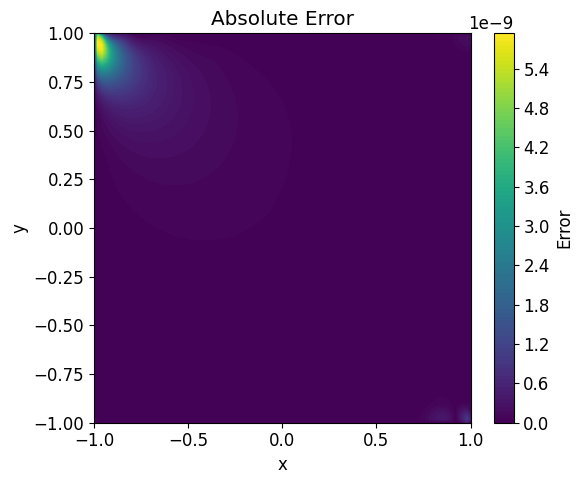

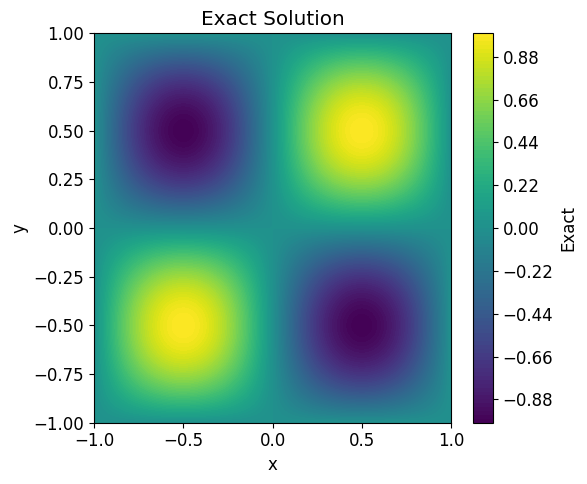

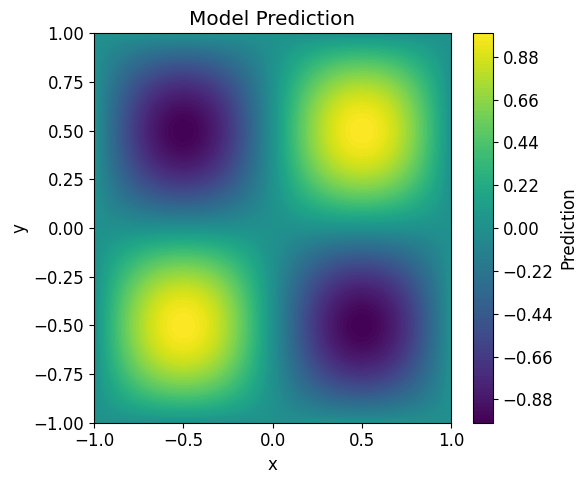

In [3]:
set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Pro = problem.PoissonBox(f, u_exact, u_exact, domain_size=1, device=device)
params = {"d": 2, "bodyBatch": 1024, "bdryBatch": 128, "lr": 0.001, "width": 500, "depth": 2, "trainStep": 142, "plotStep": 200, "writeStep": 50, "decay": 0.0001, "epsilon": 1e-3, "orthogonalpenalty": 1, "beta": 0}
startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])

startTime = time.time()
rank_orthogonal, sigma_orthogonal = utility.trainnew(model,Pro,device,params,optimizer)

In [4]:
def sample_mu_sigma(K, mu_range, sigma_range):
    """
    采样二维高斯的均值 mu 和协方差矩阵 sigma，强制 sigma 不小于下限
    """
    mu = np.random.uniform(mu_range[0], mu_range[1], size=(K, 2))
    sigma = np.zeros((K, 2, 2))
    for k in range(K):
        sigma_x = np.random.uniform(sigma_range[0], sigma_range[1])
        sigma_y = np.random.uniform(sigma_range[0], sigma_range[1])
        cov = np.random.uniform(-0.2, 0.2) * sigma_x * sigma_y  # 控制相关性
        sigma[k] = np.array([[sigma_x ** 2, cov], [cov, sigma_y ** 2]])
    return mu, sigma


def uj(points, c, mu, sigma):
    """
    计算 u_j(x, y)，输入点为 shape (N, 2)
    
    Parameters:
    points : ndarray of shape (N, 2)
        输入的点集
    c : ndarray
        每个高斯基函数的系数
    mu : ndarray
        每个高斯基函数的中心
    sigma : ndarray
        每个高斯基函数的协方差矩阵
    
    Returns:
    u : ndarray of shape (N,)
        u_j 在每个输入点的函数值
    """
    u = np.zeros(points.shape[0])
    for k in range(len(c)):
        diff = points - mu[k]  # shape: (N, 2)
        inv_sigma = np.linalg.inv(sigma[k])
        exponent = -0.5 * (inv_sigma[0,0] * diff[:,0]**2 + 
                           2 * inv_sigma[0,1] * diff[:,0] * diff[:,1] + 
                           inv_sigma[1,1] * diff[:,1]**2)
        u += c[k] * np.exp(exponent)
    return u

def laplacian_uj(points, c, mu, sigma):
    """
    计算 -Δu_j(x, y)，输入点为 shape (N, 2)
    
    Parameters:
    points : ndarray of shape (N, 2)
        输入的点集
    c : ndarray
        每个高斯基函数的系数
    mu : ndarray
        每个高斯基函数的中心
    sigma : ndarray
        每个高斯基函数的协方差矩阵
    
    Returns:
    lap_u : ndarray of shape (N,)
        -Δu_j 在每个输入点的函数值
    """
    lap_u = np.zeros(points.shape[0])

    for k in range(len(c)):
        inv_sigma = np.linalg.inv(sigma[k])
        diff = points - mu[k]  # shape: (N, 2)

        # 计算高斯核 u
        exponent = -0.5 * (inv_sigma[0, 0] * diff[:, 0]**2 +
                           2 * inv_sigma[0, 1] * diff[:, 0] * diff[:, 1] +
                           inv_sigma[1, 1] * diff[:, 1]**2)
        G = np.exp(exponent)

        # 计算 u_xx 项
        a11 = inv_sigma[0, 0]
        a12 = inv_sigma[0, 1]
        temp_x = a11 * diff[:, 0] + a12 * diff[:, 1]
        u_xx = G * (temp_x**2 - a11)

        # 计算 u_yy 项
        a21 = inv_sigma[1, 0]
        a22 = inv_sigma[1, 1]
        temp_y = a21 * diff[:, 0] + a22 * diff[:, 1]
        u_yy = G * (temp_y**2 - a22)

        lap_u += c[k] * (u_xx + u_yy)

    return -lap_u  # 返回负的拉普拉斯项（右端项）




def generate_random_function(K, mu_range=[-1, 1], sigma_range=[0.2, 0.6]):
    """
    生成完整的随机函数样本，包括 mu, sigma, c
    """
    mu, sigma = sample_mu_sigma(K, mu_range, sigma_range)
    c = np.random.randn(K)
    return mu, sigma, c

###Transfer to Box domain with different right hind side

In [5]:
Pro = problem.PoissonBox(f, u_exact, u_exact, 1, 1, device)
Pro.generate_points(params["bodyBatch"], params["bdryBatch"], "uniform")
body = Pro.data()["interior_points"]
bdry = Pro.data()["boundary_points"]

basis = lambda x: model(x)[0]
u_body = basis(body)
Nb, Mb = u_body.shape[0], u_body.shape[1]
A_body = torch.zeros(Nb, Mb, device=device)
for i in range(Mb):
    laplace = model.laplacian(body, i)  
    A_body[:, i] = (-laplace).detach()
A_bdry = basis(bdry)
A = torch.cat((A_body, A_bdry), dim=0)
A_np = A.cpu().detach().numpy()

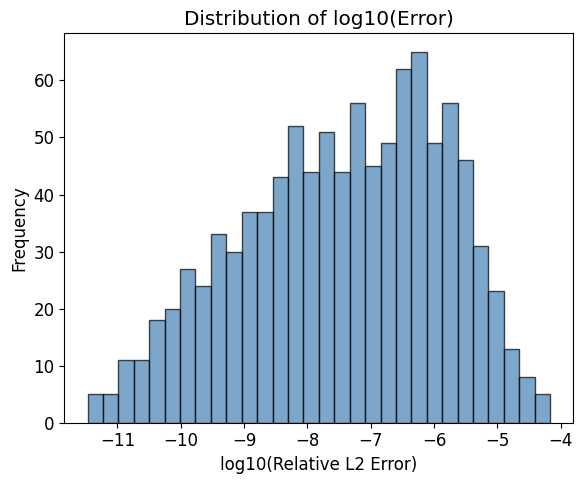

GeometricMean= 3.53e-08
IQR          = [2.49e-09, 6.66e-07]


In [6]:
set_seed(42)
K = 5
N = 1000
Errors = []
for i in range(N):
    mu, sigma, c = generate_random_function(K, mu_range=[-0.5, 0.5], sigma_range=[0.2, 1.0])
    f_body = laplacian_uj(body.detach().cpu().numpy(), c, mu, sigma)
    f_bdry = uj(bdry.detach().cpu().numpy(), c, mu, sigma)
    f_body = torch.tensor(f_body)
    f_bdry = torch.tensor(f_bdry)
    rhs = torch.cat((f_body, f_bdry), dim=0)
    rhs_np = rhs.cpu().detach().numpy()
    w, _, _, _ = lstsq(A_np, rhs_np)
    perdict = lambda x: model(x)[0] @ torch.tensor(w, device=device)
    
    n_plot = 100  # 画图用 50x50 采样点
    x = np.linspace(-1, 1, n_plot)
    y = np.linspace(-1, 1, n_plot)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    grid_points = np.stack([xx.flatten(), yy.flatten()], axis=-1)
    grid_points_torch = torch.from_numpy(grid_points)

    # 计算真实解 & 预测解
    Exact_u = torch.tensor(uj(grid_points, c, mu, sigma)).reshape(n_plot, n_plot).to(device)
    Train_u = perdict(grid_points_torch.to(device))
    Train_u = Train_u.reshape(n_plot, n_plot)
    Error = torch.abs(Exact_u - Train_u)
    Exact_u = Exact_u.detach().cpu().numpy()
    Train_u = Train_u.detach().cpu().numpy()
    Error = Error.detach().cpu().numpy()
    l2_error = np.sqrt(np.mean(Error**2))
    l2_error_rel = l2_error / np.sqrt(np.mean(Exact_u**2))
    Errors.append(l2_error_rel)
log_Errors = np.log10(Errors)

plt.figure(figsize=(6,5))
plt.hist(log_Errors, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel("log10(Relative L2 Error)")
plt.ylabel("Frequency")
plt.title("Distribution of log10(Error)")
plt.tight_layout()
plt.show()

geom_mean = 10**(np.mean(log_Errors))  
q25, q75 = np.percentile(Errors, [25, 75])

print(f"GeometricMean= {geom_mean:.2e}")
print(f"IQR          = [{q25:.2e}, {q75:.2e}]")

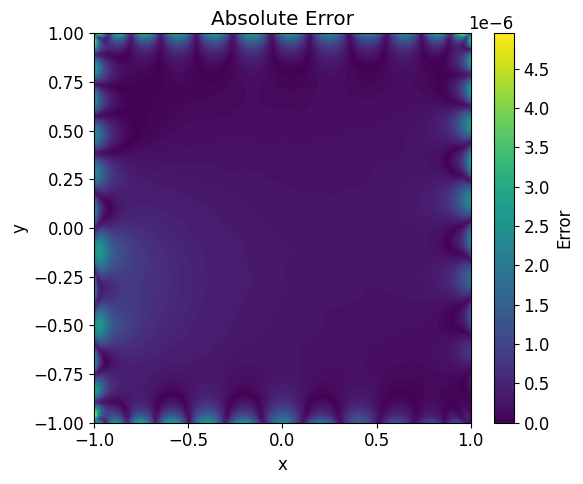

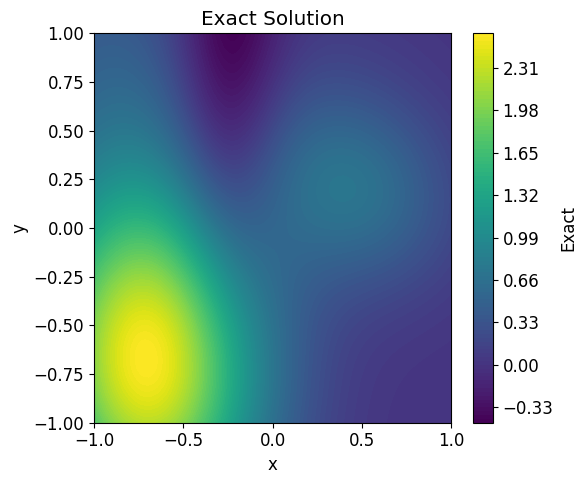

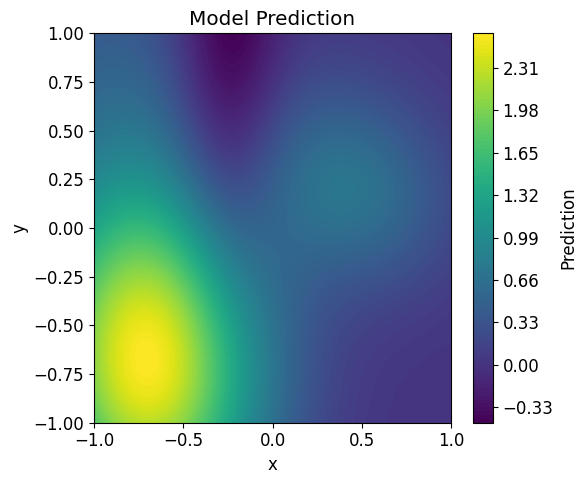

In [7]:
set_seed(42)
K = 5
N = 1
mu, sigma, c = generate_random_function(K, mu_range=[-1, 1], sigma_range=[0.2, 1,0])
f_body = laplacian_uj(body.detach().cpu().numpy(), c, mu, sigma)
f_bdry = uj(bdry.detach().cpu().numpy(), c, mu, sigma)
f_body = torch.tensor(f_body)
f_bdry = torch.tensor(f_bdry)
rhs = torch.cat((f_body, f_bdry), dim=0)
rhs_np = rhs.cpu().detach().numpy()
w, _, _, _ = lstsq(A_np, rhs_np)
perdict = lambda x: model(x)[0] @ torch.tensor(w, device=device)

n_plot = 100  # 画图用 50x50 采样点
x = np.linspace(-1, 1, n_plot)
y = np.linspace(-1, 1, n_plot)
xx, yy = np.meshgrid(x, y, indexing='ij')
grid_points = np.stack([xx.flatten(), yy.flatten()], axis=-1)
grid_points_torch = torch.from_numpy(grid_points)

# 计算真实解 & 预测解
Exact_u = torch.tensor(uj(grid_points, c, mu, sigma)).reshape(n_plot, n_plot).to(device)
Train_u = perdict(grid_points_torch.to(device))
Train_u = Train_u.reshape(n_plot, n_plot)
Error = torch.abs(Exact_u - Train_u)
Exact_u = Exact_u.detach().cpu().numpy()
Train_u = Train_u.detach().cpu().numpy()
Error = Error.detach().cpu().numpy()

plt.figure(figsize=(6, 5))
contour1 = plt.contourf(xx, yy, Error, levels=100, cmap="viridis")
plt.colorbar(contour1, label="Error")
plt.title("Absolute Error")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# === 第二张图：Exact Solution ===
plt.figure(figsize=(6, 5))
contour2 = plt.contourf(xx, yy, Exact_u, levels=100, cmap="viridis")
plt.colorbar(contour2, label="Exact")
plt.title("Exact Solution")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# === 第三张图：Model Prediction ===
plt.figure(figsize=(6, 5))
contour3 = plt.contourf(xx, yy, Train_u, levels=100, cmap="viridis")
plt.colorbar(contour3, label="Prediction")
plt.title("Model Prediction")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

### Transfer to Annulus Domain

In [8]:
Pro = problem.PoissonAnnulus(f, u_exact, u_exact,bdry_penalty=0, device=device)
Pro.generate_points(params["bodyBatch"], params["bdryBatch"], "uniform")
body = Pro.data()["interior_points"]
bdry = Pro.data()["boundary_points"]

basis = lambda x: model(x)[0]
u_body = basis(body)
Nb, Mb = u_body.shape[0], u_body.shape[1]
A_body = torch.zeros(Nb, Mb, device=device)
for i in range(Mb):
    laplace = model.laplacian(body, i)  
    A_body[:, i] = (-laplace).detach()
A_bdry = basis(bdry)
A = torch.cat((A_body, A_bdry), dim=0)
A_np = A.cpu().detach().numpy()

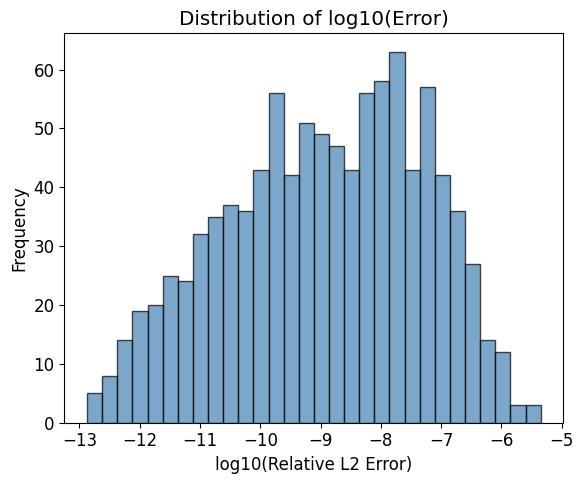

GeometricMean= 1.13e-09
IQR          = [7.12e-11, 2.15e-08]


In [9]:
set_seed(42)
K = 5
N = 1000
Errors_Annulus = []
for i in range(N):
    mu, sigma, c = generate_random_function(K, mu_range=[-0.5, 0.5], sigma_range=[0.2, 1.0])
    f_body = laplacian_uj(body.detach().cpu().numpy(), c, mu, sigma)
    f_bdry = uj(bdry.detach().cpu().numpy(), c, mu, sigma)
    f_body = torch.tensor(f_body)
    f_bdry = torch.tensor(f_bdry)
    rhs = torch.cat((f_body, f_bdry), dim=0)
    rhs_np = rhs.cpu().detach().numpy()
    w, _, _, _ = lstsq(A_np, rhs_np)
    perdict = lambda x: model(x)[0] @ torch.tensor(w, device=device)
    
    n_plot = 100  # 画图用 50x50 采样点
    x = np.linspace(-1, 1, n_plot)
    y = np.linspace(-1, 1, n_plot)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    grid_points = np.stack([xx.flatten(), yy.flatten()], axis=-1)
    grid_points_torch = torch.from_numpy(grid_points)
    r = np.sqrt(grid_points[:, 0] ** 2 + grid_points[:, 1] ** 2)
    mask = (r >= 0.5) & (r <= 1)  # 只保留在环形区域内的点
    valid_points = grid_points[mask]
    valid_points_torch = torch.tensor(valid_points)

    # 计算真实解 & 预测解
    Exact_u = torch.tensor(uj(valid_points, c, mu, sigma)).to(device)
    Train_u = perdict(valid_points_torch.to(device))
    Error = torch.abs(Exact_u - Train_u)
    Exact_u = Exact_u.detach().cpu().numpy()
    Train_u = Train_u.detach().cpu().numpy()
    Error = Error.detach().cpu().numpy()
    l2_error = np.sqrt(np.nanmean(Error**2))
    l2_error_rel = l2_error / np.sqrt(np.mean(Exact_u**2))
    Errors_Annulus.append(l2_error_rel)
    
log_Errors_Annulus = np.log10(Errors_Annulus)

plt.figure(figsize=(6,5))
plt.hist(log_Errors_Annulus, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel("log10(Relative L2 Error)")
plt.ylabel("Frequency")
plt.title("Distribution of log10(Error)")
plt.tight_layout()
plt.show()

geom_mean = 10**(np.mean(log_Errors_Annulus))  
q25, q75 = np.percentile(Errors_Annulus, [25, 75])

print(f"GeometricMean= {geom_mean:.2e}")
print(f"IQR          = [{q25:.2e}, {q75:.2e}]")

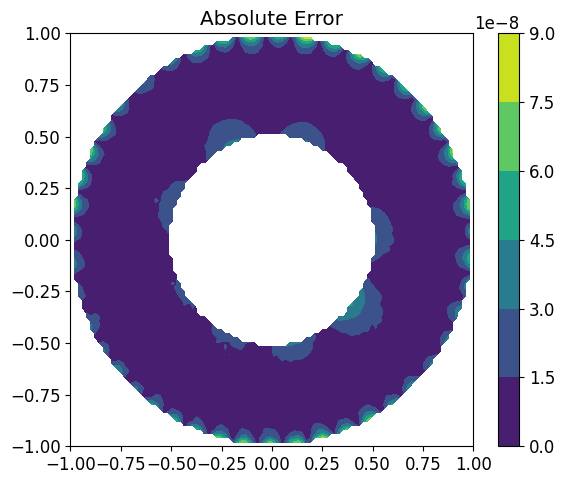

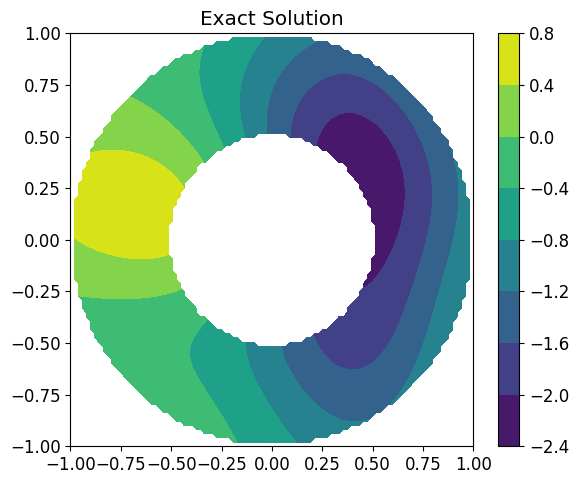

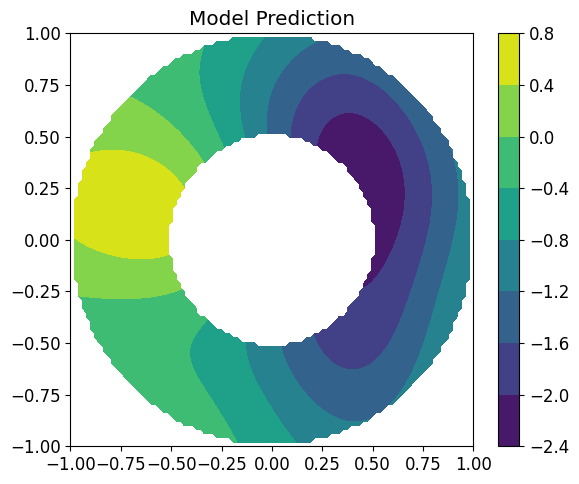

In [10]:
K = 5
N = 1
mu, sigma, c = generate_random_function(K, mu_range=[-0.5, 0.5], sigma_range=[0.2, 1.0])
f_body = laplacian_uj(body.detach().cpu().numpy(), c, mu, sigma)
f_bdry = uj(bdry.detach().cpu().numpy(), c, mu, sigma)
f_body = torch.tensor(f_body)
f_bdry = torch.tensor(f_bdry)
rhs = torch.cat((f_body, f_bdry), dim=0)
rhs_np = rhs.cpu().detach().numpy()
w, _, _, _ = lstsq(A_np, rhs_np)
perdict = lambda x: model(x)[0] @ torch.tensor(w, device=device)

n_plot = 100  # 画图用 100x100 采样点
R_out = 1
R_in = 0.5
x = np.linspace(-R_out, R_out, n_plot)
y = np.linspace(-R_out, R_out, n_plot)
xx, yy = np.meshgrid(x, y, indexing='ij')
grid_points = np.stack([xx.flatten(), yy.flatten()], axis=-1)
grid_points_torch = torch.from_numpy(grid_points).to(device)

# **去掉环形外的点**
r = np.sqrt(grid_points[:, 0] ** 2 + grid_points[:, 1] ** 2)
mask = (r >= R_in) & (r <= R_out)  # 只保留在环形区域内的点
valid_points = grid_points[mask]
valid_points_torch = torch.from_numpy(valid_points).to(device)

# 计算真实解 & 预测解
Exact_u = torch.tensor(uj(valid_points, c, mu, sigma)).to(device)
Train_u = perdict(valid_points_torch).view(-1)
Error = torch.abs(Exact_u - Train_u)

# **填充到完整网格**
Exact_u_full = torch.full((n_plot * n_plot,), float("nan"), device=device)
Train_u_full = torch.full((n_plot * n_plot,), float("nan"), device=device)
Error_full = torch.full((n_plot * n_plot,), float("nan"), device=device)

Exact_u_full[mask] = Exact_u
Train_u_full[mask] = Train_u
Error_full[mask] = Error

Exact_u_full = Exact_u_full.reshape(n_plot, n_plot).detach().cpu().numpy()
Train_u_full = Train_u_full.reshape(n_plot, n_plot).detach().cpu().numpy()
Error_full = Error_full.reshape(n_plot, n_plot).detach().cpu().numpy()

l2_error = np.sqrt(np.nanmean(Error_full**2))
l2_error_rel = l2_error / np.sqrt(np.nanmean(Exact_u_full**2))

fig1 = plt.figure(figsize=(6, 5))
ax1 = fig1.add_subplot(111)
cf1 = ax1.contourf(xx, yy, Error_full)
ax1.set_title("Absolute Error")
plt.colorbar(cf1, ax=ax1)
plt.tight_layout()
plt.show()

# === 第二张图：Exact Solution ===
fig2 = plt.figure(figsize=(6, 5))
ax2 = fig2.add_subplot(111)
cf2 = ax2.contourf(xx, yy, Exact_u_full)
ax2.set_title("Exact Solution")
plt.colorbar(cf2, ax=ax2)
plt.tight_layout()
plt.show()

# === 第三张图：Model Prediction ===
fig3 = plt.figure(figsize=(6, 5))
ax3 = fig3.add_subplot(111)
cf3 = ax3.contourf(xx, yy, Train_u_full)
ax3.set_title("Model Prediction")
plt.colorbar(cf3, ax=ax3)
plt.tight_layout()
plt.show()

### Transfer to L-shape Domain

In [11]:
Pro = problem.PoissonL(f, u_exact, u_exact,bdry_penalty=0, device=device)
Pro.generate_points(params["bodyBatch"], params["bdryBatch"], "random")
body = Pro.data()["interior_points"]
bdry = Pro.data()["boundary_points"]

basis = lambda x: model(x)[0]
u_body = basis(body)
Nb, Mb = u_body.shape[0], u_body.shape[1]
A_body = torch.zeros(Nb, Mb, device=device)
for i in range(Mb):
    laplace = model.laplacian(body, i)  
    A_body[:, i] = (-laplace).detach()
A_bdry = basis(bdry)
A = torch.cat((A_body, A_bdry), dim=0)
A_np = A.cpu().detach().numpy()

In [12]:
set_seed(42)
K = 5
N = 1000
Errors_L = []
for i in range(N):
    mu, sigma, c = generate_random_function(K, mu_range=[-0.5, 0.5], sigma_range=[0.2, 1.0])
    f_body = laplacian_uj(body.detach().cpu().numpy(), c, mu, sigma)
    f_bdry = uj(bdry.detach().cpu().numpy(), c, mu, sigma)
    f_body = torch.tensor(f_body)
    f_bdry = torch.tensor(f_bdry)
    rhs = torch.cat((f_body, f_bdry), dim=0)
    rhs_np = rhs.cpu().detach().numpy()
    w, _, _, _ = lstsq(A_np, rhs_np)
    perdict = lambda x: model(x)[0] @ torch.tensor(w, device=device)
    
    n_plot = 100  # 画图用 50x50 采样点
    x = np.linspace(-1, 1, n_plot)
    y = np.linspace(-1, 1, n_plot)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    grid_points = np.stack([xx.flatten(), yy.flatten()], axis=-1)
    grid_points_torch = torch.from_numpy(grid_points)
    mask = ~((grid_points[:, 0] >= 0) & (grid_points[:, 1] >= 0))
    valid_points = grid_points[mask]
    valid_points_torch = torch.tensor(valid_points)

    # 计算真实解 & 预测解
    Exact_u = torch.tensor(uj(valid_points, c, mu, sigma)).to(device)
    Train_u = perdict(valid_points_torch.to(device))
    Error = torch.abs(Exact_u - Train_u)
    Exact_u = Exact_u.detach().cpu().numpy()
    Train_u = Train_u.detach().cpu().numpy()
    Error = Error.detach().cpu().numpy()
    l2_error = np.sqrt(np.nanmean(Error**2))
    l2_error_rel = l2_error / np.sqrt(np.mean(Exact_u**2))
    Errors_L.append(l2_error_rel)
    
log_Errors_L = np.log10(Errors_L)   
plt.figure(figsize=(6,5))
plt.hist(log_Errors_L, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel("log10(Relative L2 Error)")
plt.ylabel("Frequency")
plt.title("Distribution of log10(Error)")
plt.tight_layout()
plt.show()


geom_mean = 10**(np.mean(log_Errors_L))
q25, q75 = np.percentile(log_Errors_L, [25, 75])

print(f"GeometricMean= {geom_mean:.2e}")
print(f"IQR          = [{q25:.2e}, {q75:.2e}]")

KeyboardInterrupt: 

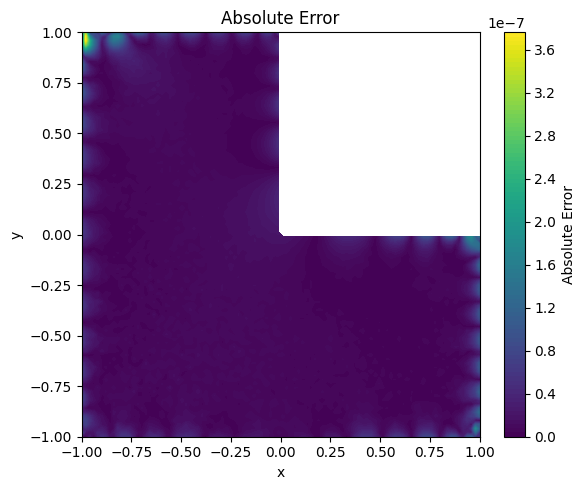

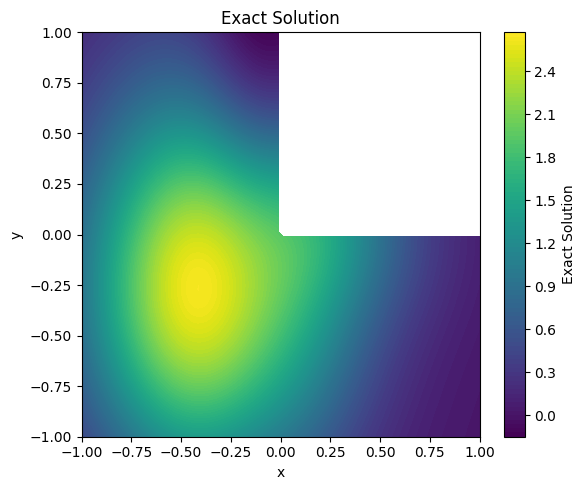

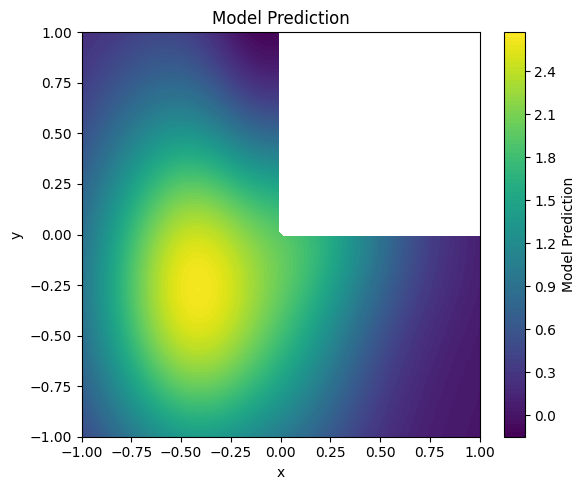

In [ ]:
set_seed(42)
K = 5
N = 1
mu, sigma, c = generate_random_function(K, mu_range=[-0.5, 0.5], sigma_range=[0.2, 1.0])
f_body = laplacian_uj(body.detach().cpu().numpy(), c, mu, sigma)
f_bdry = uj(bdry.detach().cpu().numpy(), c, mu, sigma)
f_body = torch.tensor(f_body)
f_bdry = torch.tensor(f_bdry)
rhs = torch.cat((f_body, f_bdry), dim=0)
rhs_np = rhs.cpu().detach().numpy()
w, _, _, _ = lstsq(A_np, rhs_np)
perdict = lambda x: model(x)[0] @ torch.tensor(w, device=device)

n_plot = 100  # 画图用 100x100 采样点
R_out = 1
R_in = 1
x = np.linspace(-R_out, R_out, n_plot)
y = np.linspace(-R_out, R_out, n_plot)
xx, yy = np.meshgrid(x, y, indexing='ij')
grid_points = np.stack([xx.flatten(), yy.flatten()], axis=-1)
grid_points_torch = torch.from_numpy(grid_points).to(device)

# **去掉环形外的点**
mask = ~((grid_points[:, 0] >= 0) & (grid_points[:, 1] >= 0))
valid_points = grid_points[mask]
valid_points_torch = torch.from_numpy(valid_points).to(device)

# 计算真实解 & 预测解
Exact_u = torch.tensor(uj(valid_points_torch.detach().cpu().numpy(), c, mu, sigma)).to(device)
Train_u = perdict(valid_points_torch ).view(-1)
Error = torch.abs(Exact_u - Train_u)

# **填充到完整网格**
Exact_u_full = torch.full((n_plot * n_plot,), float("nan"), device=device)
Train_u_full = torch.full((n_plot * n_plot,), float("nan"), device=device)
Error_full = torch.full((n_plot * n_plot,), float("nan"), device=device)

Exact_u_full[mask] = Exact_u
Train_u_full[mask] = Train_u
Error_full[mask] = Error

Exact_u_full = Exact_u_full.reshape(n_plot, n_plot).detach().cpu().numpy()
Train_u_full = Train_u_full.reshape(n_plot, n_plot).detach().cpu().numpy()
Error_full = Error_full.reshape(n_plot, n_plot).detach().cpu().numpy()

l2_error = np.sqrt(np.nanmean(Error_full**2))
l2_error_rel = l2_error / np.sqrt(np.nanmean(Exact_u_full**2))

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
cf = ax.contourf(xx, yy, Error_full, levels=100, cmap="viridis")
cbar = plt.colorbar(cf, ax=ax)
cbar.set_label("Absolute Error")
ax.set_title("Absolute Error")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.tight_layout()
plt.show()

# === 第二张图：Exact Solution (2D) ===
fig2 = plt.figure(figsize=(6, 5))
ax2 = fig2.add_subplot(111)
cf2 = ax2.contourf(xx, yy, Exact_u_full, levels=100, cmap="viridis")
cbar2 = plt.colorbar(cf2, ax=ax2)
cbar2.set_label("Exact Solution")
ax2.set_title("Exact Solution")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
plt.tight_layout()
plt.show()

# === 第三张图：Model Prediction (2D) ===
fig3 = plt.figure(figsize=(6, 5))
ax3 = fig3.add_subplot(111)
cf3 = ax3.contourf(xx, yy, Train_u_full, levels=100, cmap="viridis")
cbar3 = plt.colorbar(cf3, ax=ax3)
cbar3.set_label("Model Prediction")
ax3.set_title("Model Prediction")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.tight_layout()
plt.show()